# INFORMATION RETRIEVAL PROJECT

---
## Gender stereotypes in parliamentary speeches

In word embedding models, each word is assigned to a high-dimensional vector such that the geometry of the vectors captures semantic relations between the words – e.g. vectors being closer together has been shown to correspond to more similar words. Recent works in machine learning demonstrate that word embeddings also capture common stereotypes, as these stereotypes are likely to be present, even if subtly, in the large corpora of training texts. These stereotypes are automatically learned by the embedding algorithm and could be problematic in many context if the embedding is then used for sensitive applications such as search rankings, product recommendations, or translations. An important direction of research is on developing algorithms to debias the word embeddings.

This project aims to use the word embeddings to study historical trends – specifically trends in the gender and ethnic stereotypes in the Italian parliamentary speeches from 1948 to 2020.

In [1]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import os

from INFORET_project import load_embed_model
# import matplotlib.pylab as plt
pd.set_option("display.max_rows", 100, "display.max_columns", 100)

/Users/Niki/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
from INFORET_project import YEARS

In [3]:
YEARS

['1948_1968', '1968_1985', '1985_2000', '2000_2020']

In [4]:
model = load_embed_model(YEARS[0])

In [7]:
model = load_embed_model(YEARS[1])

In [8]:
model = load_embed_model(YEARS[2])

In [16]:
model = load_embed_model(YEARS[3])

# 2. ANALYSIS OF GENDER STEREOTYPES BY YEARS

# 1) PRELIMINARY ANALYSIS
Create a group of gendered words and retrieve the mean vector, then use it to retrieve the most similar words to the vector 

In [4]:
from INFORET_project import similar_to_avg_vector 
from INFORET_project.data import gendered_neutral_words

In [3]:
!ls -lh we_models

total 1088408
-rw-r--r--  1 Niki  staff   4,5M 29 Giu 10:39 W2V_by_years_1948_1968
-rw-r--r--  1 Niki  staff    84M 29 Giu 10:39 W2V_by_years_1948_1968.trainables.syn1neg.npy
-rw-r--r--  1 Niki  staff    84M 29 Giu 10:40 W2V_by_years_1948_1968.wv.vectors.npy
-rw-r--r--  1 Niki  staff   3,5M 29 Giu 10:40 W2V_by_years_1968_1985
-rw-r--r--  1 Niki  staff    65M 29 Giu 10:40 W2V_by_years_1968_1985.trainables.syn1neg.npy
-rw-r--r--  1 Niki  staff    65M 29 Giu 10:41 W2V_by_years_1968_1985.wv.vectors.npy
-rw-r--r--  1 Niki  staff   3,0M 29 Giu 10:41 W2V_by_years_1985_2000
-rw-r--r--  1 Niki  staff    57M 29 Giu 10:41 W2V_by_years_1985_2000.trainables.syn1neg.npy
-rw-r--r--  1 Niki  staff    57M 29 Giu 10:41 W2V_by_years_1985_2000.wv.vectors.npy
-rw-r--r--  1 Niki  staff   2,8M 29 Giu 10:41 W2V_by_years_2000_2020
-rw-r--r--  1 Niki  staff    52M 29 Giu 10:42 W2V_by_years_2000_2020.trainables.syn1neg.npy
-rw-r--r--  1 Niki  staff    52M 29 Giu 10:42 W2V_by_years_2000_2020.wv.vectors.npy


In [12]:
for i,year in enumerate(YEARS):
    print(f"\nYears: {YEARS[i]}")
    model = load_embed_model(YEARS[i])
    
    for gender in ['male','female']:
        print(f"\nMost similar words to {gender} vector:")
        _ = similar_to_avg_vector(model.wv, gendered_neutral_words[gender]) # SISTEMA!


Years: 1948_1968

Most similar words to male vector:


[('Zappelli', 0.5698506832122803),
 ('Settembrini', 0.5646949410438538),
 ('lei', 0.562781572341919),
 ('Lho', 0.5611302256584167),
 ('maschiare', 0.5558352470397949),
 ('divulgatore', 0.5550841093063354),
 ('Uscito', 0.5509503483772278),
 ('brav', 0.5507361888885498),
 ('piglio', 0.5503260493278503),
 ('Spellanzon', 0.5499021410942078),
 ('Montemartini', 0.5494170188903809),
 ('Maffi', 0.545027494430542),
 ('Roggero', 0.5446869134902954),
 ('possedette', 0.543790876865387),
 ('casata', 0.5433430075645447),
 ('Olgiati', 0.5430217981338501),
 ('causidica', 0.5428649187088013),
 ('novantenne', 0.5408570170402527),
 ('Ricordati', 0.539644181728363),
 ('Filpo', 0.5394607186317444)]


Most similar words to female vector:


[('maschio', 0.6027352809906006),
 ('coniugato', 0.5403891801834106),
 ('bambino', 0.5359815359115601),
 ('madre', 0.5300886034965515),
 ('A4110ra', 0.5290261507034302),
 ('Duro', 0.5266222953796387),
 ('pizza', 0.5260553359985352),
 ('traviata', 0.5229917764663696),
 ('caramellare', 0.5219253301620483),
 ('Speravano', 0.519498884677887),
 ('educabili', 0.5186226963996887),
 ('piazzarsi', 0.5178252458572388),
 ('tenerissima', 0.5173928141593933),
 ('ragazza', 0.516727864742279),
 ('PerchP', 0.5149996280670166),
 ('Parlavamo', 0.5093346238136292),
 ('epoi', 0.5088962316513062),
 ('magliaie', 0.5078704953193665),
 ('Nbn', 0.507202684879303),
 ('ragazzina', 0.5067441463470459)]


Years: 1968_1985

Most similar words to male vector:


[('imparentare', 0.5919234752655029),
 ('dabbene', 0.5873482823371887),
 ('Cascavilla', 0.5757697224617004),
 ('moraleggiare', 0.57254558801651),
 ('Pascal', 0.5718967914581299),
 ('degnissima', 0.5694552063941956),
 ('toccarla', 0.5629111528396606),
 ('incestuoso', 0.5626682639122009),
 ('Mahler', 0.5580506324768066),
 ('Pagheranno', 0.5543779730796814),
 ('Ponzo', 0.5536849498748779),
 ('Studenti', 0.5516732931137085),
 ('andarvi', 0.5507052540779114),
 ('integerrimo', 0.5496920943260193),
 ('focoso', 0.5495660305023193),
 ('sottoccupato', 0.5480859279632568),
 ('peccatore', 0.5471469759941101),
 ('svillaneggiare', 0.5464788675308228),
 ('suggestivamente', 0.5458648800849915),
 ('violabili', 0.545601487159729)]


Most similar words to female vector:


[('emancipato', 0.6487357020378113),
 ('sessualmente', 0.6152198314666748),
 ('maschiare', 0.6015832424163818),
 ('giovanissime', 0.5884872674942017),
 ('nubile', 0.5852416157722473),
 ('focomelico', 0.5786728858947754),
 ('55°', 0.5733279585838318),
 ('evirare', 0.5684111714363098),
 ('lei', 0.5655562281608582),
 ('lesbica', 0.565072774887085),
 ('abortire', 0.5640296339988708),
 ('ragazza', 0.5634415149688721),
 ('sgraziato', 0.5633205771446228),
 ('incinto', 0.5623881220817566),
 ('Resti', 0.5620538592338562),
 ('puerpera', 0.561506450176239),
 ('Vapona', 0.5599506497383118),
 ('malformato', 0.5562317371368408),
 ('nutrice', 0.5554565191268921),
 ('incestuoso', 0.5538656711578369)]


Years: 1985_2000

Most similar words to male vector:


[('capoccia', 0.5751026272773743),
 ('supplicare', 0.5648277401924133),
 ('evangelista', 0.5597399473190308),
 ('coglione', 0.5544094443321228),
 ('prostituire', 0.5524687767028809),
 ('tenerezza', 0.5514913201332092),
 ('aguzzino', 0.5504509210586548),
 ('Nietzsche', 0.5490137338638306),
 ('immodestamente', 0.545851469039917),
 ('sentirla', 0.5446656942367554),
 ('battagliero', 0.5441685914993286),
 ('Votano', 0.5432336330413818),
 ('squartare', 0.542973518371582),
 ('Parlava', 0.5422471165657043),
 ('abate', 0.5420100092887878),
 ('cannonata', 0.5413274765014648),
 ('ubriacare', 0.5363138318061829),
 ('motoretta', 0.5358209609985352),
 ('Arbore', 0.5346950888633728),
 ('Milton', 0.5343030691146851)]


Most similar words to female vector:


[('divorziato', 0.5739867091178894),
 ('menopausa', 0.5716233849525452),
 ('giovanissime', 0.5603377819061279),
 ('incinto', 0.558162271976471),
 ('partoriente', 0.5513758659362793),
 ('sieropositivo', 0.551144540309906),
 ('monoparentali', 0.5507063269615173),
 ('empowerment', 0.5504602789878845),
 ('motoretta', 0.5501375198364258),
 ('bambino', 0.548194408416748),
 ('single', 0.546561062335968),
 ('bambina', 0.5425636768341064),
 ('persona', 0.5407829284667969),
 ('ragazza', 0.5405844449996948),
 ('accudire', 0.5405091643333435),
 ('adulto', 0.5365861654281616),
 ('giovane', 0.5364285707473755),
 ('procreare', 0.5351355075836182),
 ('studentessa', 0.5350608229637146),
 ('maciullare', 0.5350210070610046)]


Years: 2000_2020

Most similar words to male vector:


[('moderatore', 0.5495796799659729),
 ('magistrate', 0.537135124206543),
 ('Uomini', 0.525381326675415),
 ('probo', 0.5215122103691101),
 ('anonimamente', 0.518482506275177),
 ('gesuita', 0.517815887928009),
 ('Mensorio', 0.5054284930229187),
 ('Franchi', 0.5021278262138367),
 ('PadoaSchioppa', 0.5015751719474792),
 ('Masih', 0.5006906390190125),
 ('Rapisarda', 0.49734416604042053),
 ('Restituiamo', 0.49563267827033997),
 ('Pinchera', 0.4954855442047119),
 ('eroicamente', 0.4952343702316284),
 ('icari', 0.49391478300094604),
 ('Castiglioni', 0.49375438690185547),
 ('semianalfabeta', 0.4926125407218933),
 ('onorabile', 0.49101564288139343),
 ('Sponziello', 0.4908043444156647),
 ('Dracula', 0.4868161976337433)]


Most similar words to female vector:


[('incinto', 0.61652010679245),
 ('maschiare', 0.5876336693763733),
 ('bambina', 0.5753710865974426),
 ('spose', 0.5685369372367859),
 ('uomini', 0.5532326102256775),
 ('Uomini', 0.5529881715774536),
 ('picchiata', 0.5529308915138245),
 ('normodotate', 0.5496178865432739),
 ('genealogia', 0.5464109182357788),
 ('ragazza', 0.5432000756263733),
 ('monoparentali', 0.5316020846366882),
 ('fattrice', 0.5290380716323853),
 ('puerpera', 0.5267908573150635),
 ('femminilita', 0.5266191363334656),
 ('giovanissime', 0.5249960422515869),
 ('persona', 0.5235183835029602),
 ('bambino', 0.5234599113464355),
 ('bisessuale', 0.5211064219474792),
 ('giovanissima', 0.5206022262573242),
 ('menopausa', 0.5193460583686829)]

# 2) ANALOGIES

In [5]:
from INFORET_project import Analogies
from INFORET_project.data import gendered_neutral_words

In [3]:
model = load_embed_model('1948_1968')

In [6]:
analogies = Analogies(model.wv)

In [17]:
analogies.generate_analogies(n_analogies=100, seed=['uomo','donna'], use_avg_gender=False,
                            multiple=False, delta=1., restrict_vocab=10000,
                            unrestricted=True)

,uomo,donna,distance,score,most_x,most_y,match
0,uomini,donna,0.836140,0.001176,uomo,donna,False
1,imprendere,impresa,0.869066,0.001040,impresa,imprendere,False
2,immigrare,immigrato,0.944050,0.001001,immigrato,immigrare,False
3,amicare,amico,0.963701,0.000994,amico,amicare,False
4,figliare,bambina,0.986153,0.000976,uomo,figliare,False
5,incenerimento,discarica,0.970220,0.000870,discarica,incenerimento,False
6,padre,madre,0.880906,0.000867,uomo,padre,False
7,estorsione,prostituzione,0.940585,0.000855,prostituzione,estorsione,False
8,Arma,Forze,0.976449,0.000846,Forze,Arma,False
9,barbarie,violenza,0.991629,0.000819,uomo,barbarie,False


In [7]:
analogies.generate_analogies(n_analogies=100, use_avg_gender=True,
                            multiple=False, delta=1., restrict_vocab=10000,
                            unrestricted=True)

,female_avg,male_avg,distance,score,most_x,most_y,match
0,ella,egli,0.942863,0.001969,egli,ella,False
1,lei,lui,0.722058,0.001842,lui,lei,False
2,occidentale,occidente,0.775401,0.001315,occidente,occidentale,False
3,Ella,Egli,0.842111,0.001312,Egli,Ella,False
4,donna,giovane,0.997564,0.001259,giovane,donna,False
...,...,...,...,...,...,...,...
95,preoccuparci,preoccuparsi,0.888398,0.000759,preoccuparsi,preoccuparci,False
96,13,5,0.769558,0.000758,5,13,False
97,vergognoso,inammissibile,0.994128,0.000758,inammissibile,vergognoso,False
98,soltanto,soprattutto,0.936357,0.000758,soprattutto,soltanto,False


----

Create a list of adjectives to test with analogies: Inspired from https://github.com/nikhgarg/EmbeddingDynamicStereotypes and WEAT test

## ANALOGIES DISTANCE BIAS

**Analogies_Distance_Bias** works by retrieving analogies for each neutral word with one gender as positive and the other as negative, then the average similarity between the group of words retrieved and both gendered words is calculated. If there is a difference in the two similarities, it is probable that the words similar to the neutral word are more related to one gender than to the other. Ideally, if there wasn't any stereotype the similarities should be 
The bias is calculated as the difference in the 2 similarities. <br>
The analogy for the same word is calculated both by using as positive one gender and then the other one as positive. 

In [5]:
from INFORET_project.data import gendered_neutral_words
from INFORET_project import Analogies_Distance_Bias

In [6]:
score = Analogies_Distance_Bias(model.wv,
                                gender_female='donna',
                                gender_male='uomo',
                                type_most_similar = 'cosmul')

In [7]:
top_bias = score.get_top_bias(pred_positive_word='adj_appearence')


Word: brutto
Similarity of 'male' analogies to 'male': 0.4240516021847725, to 'female': 0.12895660232752562
Bias for 'male' analogies: 0.29509499985724685
Similarity of 'female' analogies to 'male': 0.23219432383775712, to 'female': 0.4980472296476364
Bias for 'female' analogies: 0.2658529058098793

Word: rozzo
Similarity of 'male' analogies to 'male': 0.4410634711384773, to 'female': 0.16383448615670204
Bias for 'male' analogies: 0.2772289849817753
Similarity of 'female' analogies to 'male': 0.196292395144701, to 'female': 0.4567902535200119
Bias for 'female' analogies: 0.2604978583753109

Word: piacevole
Similarity of 'male' analogies to 'male': 0.4228265553712845, to 'female': 0.16422654390335084
Bias for 'male' analogies: 0.25860001146793365
Similarity of 'female' analogies to 'male': 0.16246785651892423, to 'female': 0.4143325835466385
Bias for 'female' analogies: 0.25186472702771423

Word: bello
Similarity of 'male' analogies to 'male': 0.4440027758479118, to 'female': 0.1678279

In [8]:
score.print_top_analogies()


Word: brutto

Positive gender: male


[('brutto', 0.5006075524125156),
 ('uomo', 0.5005223682383805),
 ('bruttare', 0.5004065489840138),
 ('hobby', 0.5003803105203399),
 ('araldo', 0.5003687344089883),
 ('inquisitore', 0.500366682238291),
 ('eclettico', 0.5003541856268412),
 ('illustre', 0.5003536100728226),
 ('lapsus', 0.500351871846717),
 ('operetta', 0.5003493893461514)]

Positive gender: female


[('brutto', 0.5005600859855832),
 ('donna', 0.5004986385057769),
 ('ragazza', 0.5004032723367208),
 ('casalingo', 0.500328544216722),
 ('bello', 0.5003203944201551),
 ('coniugato', 0.5003145616937776),
 ('bambina', 0.5003131384860301),
 ('madre', 0.5003053465979763),
 ('traviata', 0.5002912342907856),
 ('passeggiatrice', 0.5002908317425176)]


Word: rozzo

Positive gender: male


[('rozzo', 0.5006219039055707),
 ('uomo', 0.5005169892754816),
 ('inquisitore', 0.500455419909462),
 ('araldo', 0.5004371153029402),
 ('utilitarismo', 0.5004190011979728),
 ('concettualismo', 0.5003995990067123),
 ('esagitare', 0.5003968274480199),
 ('bizzoso', 0.500393146376239),
 ('nichilismo', 0.5003905816233016),
 ('barricadiero', 0.50038961973162)]

Positive gender: female


[('rozzo', 0.5005457362251707),
 ('donna', 0.5004789119451701),
 ('spudorato', 0.500337447730483),
 ('ragazza', 0.5003359080371427),
 ('casalingo', 0.5003239890975809),
 ('lavoratrice', 0.5003226970636082),
 ('atrocemente', 0.5003110050711828),
 ('corredo', 0.5003085493125684),
 ('manganare', 0.5003079792662748),
 ('semioccupati', 0.5003073527299212)]


Word: piacevole

Positive gender: male


[('piacevole', 0.5005808909863496),
 ('uomo', 0.5004710308068522),
 ('inquisitore', 0.5004177921472504),
 ('gioviale', 0.5003904707894042),
 ('contradittore', 0.5003837025546597),
 ('lapsus', 0.5003779481209311),
 ('humour', 0.500376269896909),
 ('dolciastro', 0.5003737697720553),
 ('saggista', 0.5003723295191609),
 ('scontroso', 0.5003714864989046)]

Positive gender: female


[('piacevole', 0.5005867460323099),
 ('donna', 0.500473957698147),
 ('ragazza', 0.5003692248447655),
 ('lcro', 0.5003140290373874),
 ('mamma', 0.5003009791197706),
 ('porcheria', 0.5002964297982023),
 ('femmina', 0.5002946536095313),
 ('domenicale', 0.5002942181836219),
 ('bambina', 0.5002928912929334),
 ('cinematografo', 0.5002928110929492)]


Word: bello

Positive gender: male


[('bello', 0.5005534660074376),
 ('uomo', 0.5004755692305171),
 ('inquisitore', 0.5003749456828501),
 ('insignire', 0.5003735403831805),
 ('immaginifico', 0.5003704779589985),
 ('araldo', 0.5003699806064499),
 ('poesia', 0.5003673813303188),
 ('epoque', 0.500356443934652),
 ('saggista', 0.5003536043434805),
 ('amicare', 0.5003528935286186)]

Positive gender: female


[('bello', 0.5006141729687194),
 ('donna', 0.5005059171087611),
 ('ragazza', 0.5003826497372391),
 ('madre', 0.5003454176428281),
 ('Sovraintendenza', 0.5003402013579572),
 ('Belle', 0.5003192957876542),
 ('Accademie', 0.5003098333607426),
 ('arto', 0.5003065482545623),
 ('femmina', 0.500306205783999),
 ('tessitrici', 0.5003041106575091)]


Word: carino

Positive gender: male


[('carino', 0.5005172475390353),
 ('uomo', 0.5004332181520663),
 ('abilitA', 0.5003347327363333),
 ('Iiberth', 0.5003334800018048),
 ('araldo', 0.5003281758217286),
 ('Eiar', 0.5003205540286989),
 ('chiazzare', 0.5003178634411751),
 ('opt', 0.5003178626960983),
 ('potentissimo', 0.5003108863626589),
 ('bonini', 0.5003107381042139)]

Positive gender: female


[('carino', 0.500650398403555),
 ('donna', 0.5004997780664112),
 ('nutrice', 0.5003819799889268),
 ('lir', 0.5003759527275314),
 ('manganare', 0.5003670921004102),
 ('erie', 0.500366181472612),
 ('ragazza', 0.5003655861061836),
 ('lavoratrice', 0.5003513395646892),
 ('autocolonne', 0.5003489961904586),
 ('madre', 0.5003463264801459)]

In [9]:
top_bias

[('brutto', (0.29509499985724685, 0.2658529058098793)),
 ('rozzo', (0.2772289849817753, 0.2604978583753109)),
 ('piacevole', (0.25860001146793365, 0.25186472702771423)),
 ('bello', (0.2761748660355806, 0.2336318954825401)),
 ('carino', (0.21475374847650527, 0.2890594944357872)),
 ('splendido', (0.2823390983045101, 0.2065805122256279)),
 ('sensuale', (0.2635294824838638, 0.2243047580122948)),
 ('frivolo', (0.25665763914585116, 0.20820132493972776)),
 ('magro', (0.15842187367379668, 0.299074771720916)),
 ('grasso', (0.1626533795148134, 0.17403984862030486))]

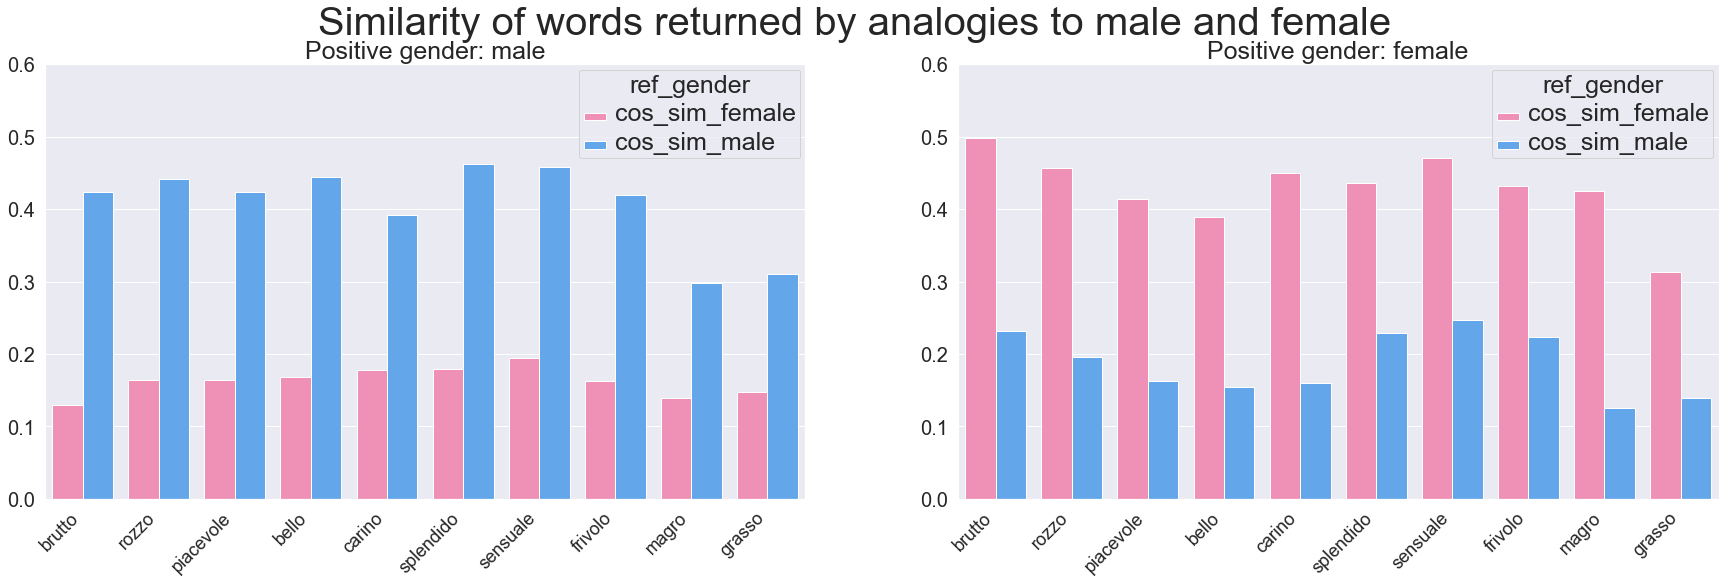

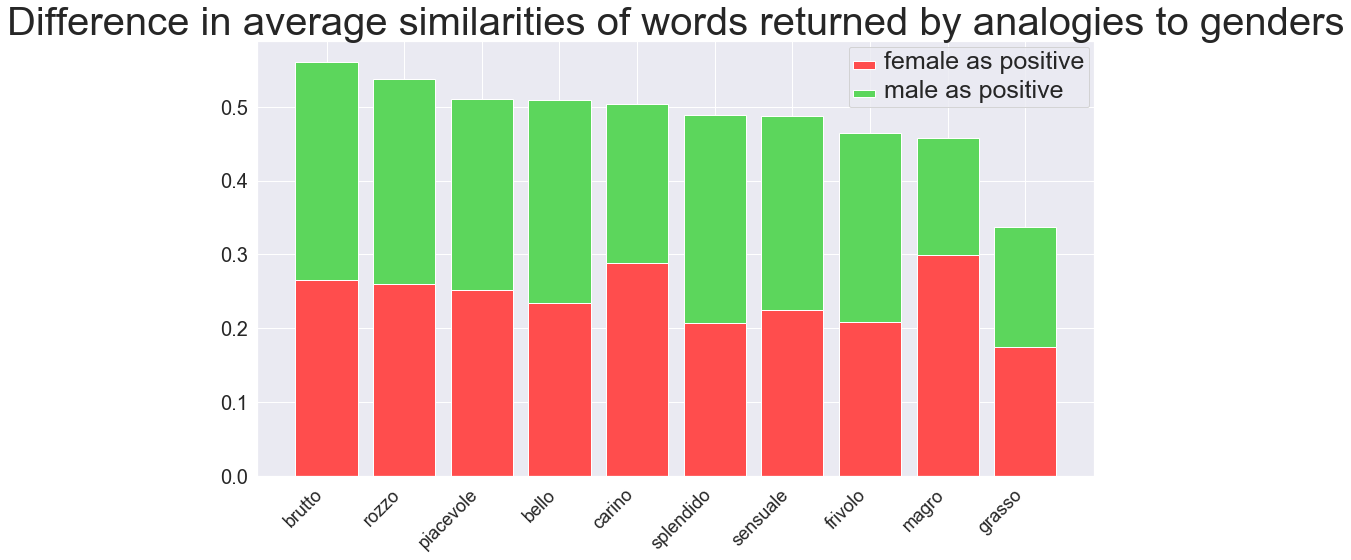

In [10]:
score.plot_bias()

---

In [11]:
score = Analogies_Distance_Bias(model.wv,
                                use_avg_gender=True,
                                type_most_similar = 'cosadd')

In [12]:
top_bias = score.get_top_bias(pred_positive_word='family')


Word: accudire
Similarity of 'male' analogies to 'male': 0.25668581277132035, to 'female': 0.1820064939558506
Bias for 'male' analogies: 0.07467931881546974
Similarity of 'female' analogies to 'male': 0.30427939891815187, to 'female': 0.37619348913431166
Bias for 'female' analogies: 0.0719140902161598

Word: matrimonio
Similarity of 'male' analogies to 'male': 0.3377647399902344, to 'female': 0.2666329726576805
Bias for 'male' analogies: 0.07113176733255389
Similarity of 'female' analogies to 'male': 0.33030027225613595, to 'female': 0.3818299904465675
Bias for 'female' analogies: 0.05152971819043156

Word: bambino
Similarity of 'male' analogies to 'male': 0.4203109800815582, to 'female': 0.4462025463581085
Bias for 'male' analogies: 0.025891566276550315
Similarity of 'female' analogies to 'male': 0.3692569434642792, to 'female': 0.4500099837779999
Bias for 'female' analogies: 0.08075304031372071

Word: famiglia
Similarity of 'male' analogies to 'male': 0.37169394791126253, to 'female

In [13]:
score.print_top_analogies()


Word: accudire

Positive gender: male


[('dedicarsi', 0.004445362687110901),
 ('procurarsi', 0.003897855281829834),
 ('sacrificare', 0.0038402104377746583),
 ('dedicare', 0.0038223356008529664),
 ('adempiere', 0.0036985045671463013),
 ('sostentamento', 0.0036698457598686217),
 ('pasto', 0.003458617329597473),
 ('adattare', 0.0033995354175567626),
 ('esplicare', 0.0033927419781684875),
 ('assolvere', 0.003356236219406128)]

Positive gender: female


[('mangiare', 0.004226142764091492),
 ('bambino', 0.0037913140654563904),
 ('andarsene', 0.0037820088863372804),
 ('pulizia', 0.0037592536211013793),
 ('domestico', 0.003706730604171753),
 ('ragazza', 0.003608248233795166),
 ('mamma', 0.003576974272727966),
 ('tranquillamente', 0.0035543090105056765),
 ('dedicarsi', 0.0035467857122421266),
 ('ora', 0.003395317494869232)]


Word: matrimonio

Positive gender: male


[('matrimonio', 0.008714920282363892),
 ('coniuge', 0.004453501105308533),
 ('contrarre', 0.0040754228830337524),
 ('figliare', 0.004054704904556275),
 ('nullita', 0.003772009313106537),
 ('contrattare', 0.0037107190489768984),
 ('figlio', 0.003701685667037964),
 ('genitore', 0.003638618290424347),
 ('religioso', 0.0036263853311538697),
 ('erede', 0.003617284297943115)]

Positive gender: female


[('matrimonio', 0.008818765878677368),
 ('coniuge', 0.003994110226631165),
 ('madre', 0.003804255127906799),
 ('figlio', 0.0037482964992523195),
 ('minorenne', 0.0036943888664245604),
 ('nullita', 0.003693387508392334),
 ('licenziamento', 0.003666011095046997),
 ('sesso', 0.003582318425178528),
 ('bambino', 0.003506814241409302),
 ('ragazza', 0.0034795206785202025)]


Word: bambino

Positive gender: male


[('bambino', 0.008584889173507691),
 ('bimbo', 0.006671656370162964),
 ('ragazzo', 0.006267432570457459),
 ('figlio', 0.005902101397514343),
 ('genitore', 0.005880438685417175),
 ('fanciullo', 0.005782114267349243),
 ('creatura', 0.005306261777877808),
 ('madre', 0.005008050799369812),
 ('malato', 0.004983475804328919),
 ('padre', 0.004940121173858642)]

Positive gender: female


[('bambino', 0.00896656334400177),
 ('bimbo', 0.006902187466621399),
 ('ragazzo', 0.006570672988891602),
 ('fanciullo', 0.006181245446205139),
 ('ragazza', 0.005692279934883118),
 ('madre', 0.005679070353507996),
 ('ammalato', 0.005560184717178345),
 ('figlio', 0.005275740623474121),
 ('ricoverato', 0.005261427760124207),
 ('scolaro', 0.005137016773223877)]


Word: famiglia

Positive gender: male


[('famiglia', 0.008747725486755372),
 ('famiglio', 0.006578624248504639),
 ('familiare', 0.005478525161743164),
 ('figlio', 0.005005384087562561),
 ('genitore', 0.004810256659984588),
 ('padre', 0.0046809127926826476),
 ('moglie', 0.004532037377357483),
 ('figliare', 0.004367718994617462),
 ('podere', 0.004027146697044372),
 ('colonico', 0.003988499343395233)]

Positive gender: female


[('famiglia', 0.008784778714179993),
 ('famiglio', 0.006578373312950134),
 ('madre', 0.005178713798522949),
 ('figlio', 0.0051274895668029785),
 ('bambino', 0.0050285434722900394),
 ('familiare', 0.005027446746826172),
 ('moglie', 0.004899892508983612),
 ('ragazza', 0.004484929442405701),
 ('mamma', 0.004457286298274994),
 ('colonico', 0.00441476970911026)]


Word: figlio

Positive gender: male


[('figlio', 0.008743928670883179),
 ('genitore', 0.006900186538696289),
 ('figliare', 0.0062721347808837894),
 ('padre', 0.005848220586776733),
 ('moglie', 0.005352215766906738),
 ('coniuge', 0.005329657196998596),
 ('fratello', 0.0052834200859069825),
 ('famiglia', 0.005029486417770386),
 ('sorella', 0.004891587793827057),
 ('bambino', 0.004759061336517334)]

Positive gender: female


[('figlio', 0.008788654804229737),
 ('genitore', 0.006400023698806763),
 ('bambino', 0.006330084204673767),
 ('madre', 0.0059287166595458985),
 ('moglie', 0.005692713260650635),
 ('bimbo', 0.005540204048156738),
 ('ragazzo', 0.005483008623123169),
 ('orfano', 0.00528549075126648),
 ('figliare', 0.005228322744369507),
 ('famiglia', 0.005103728175163269)]

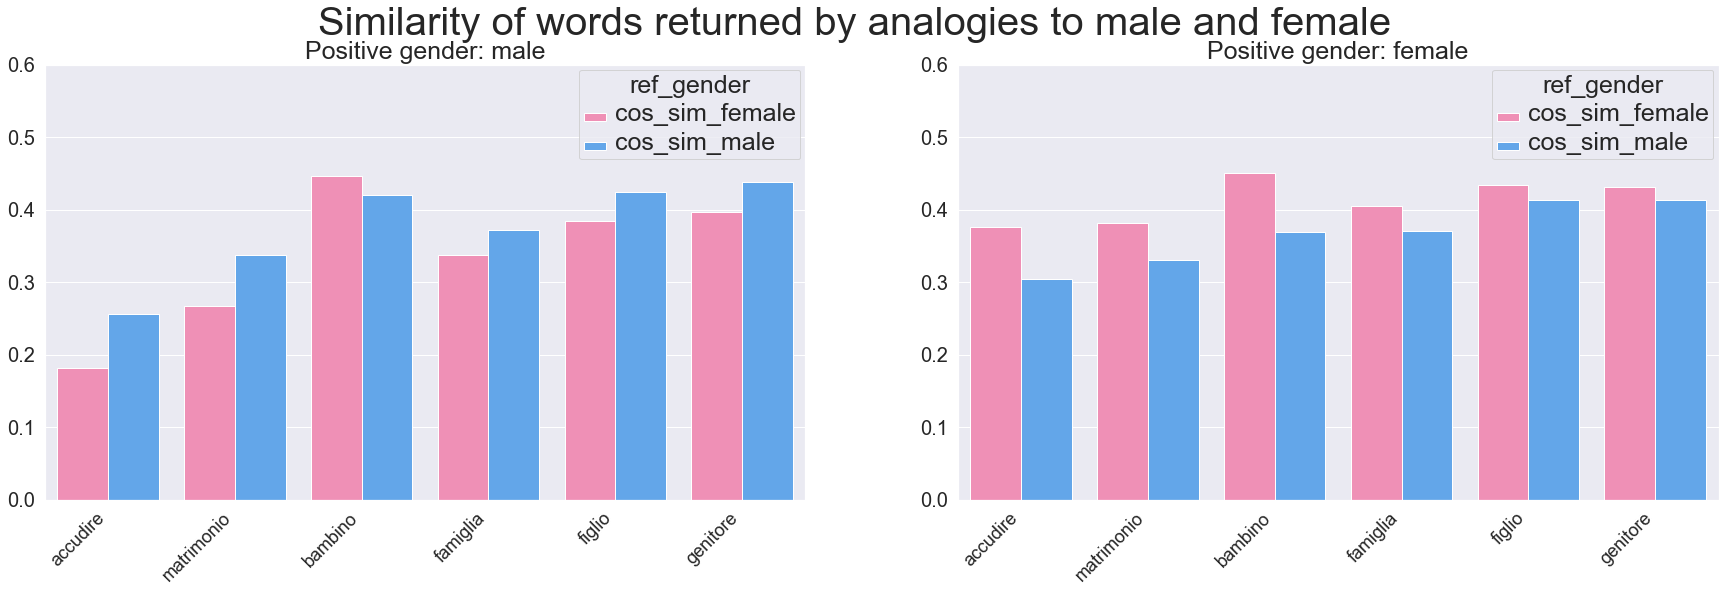

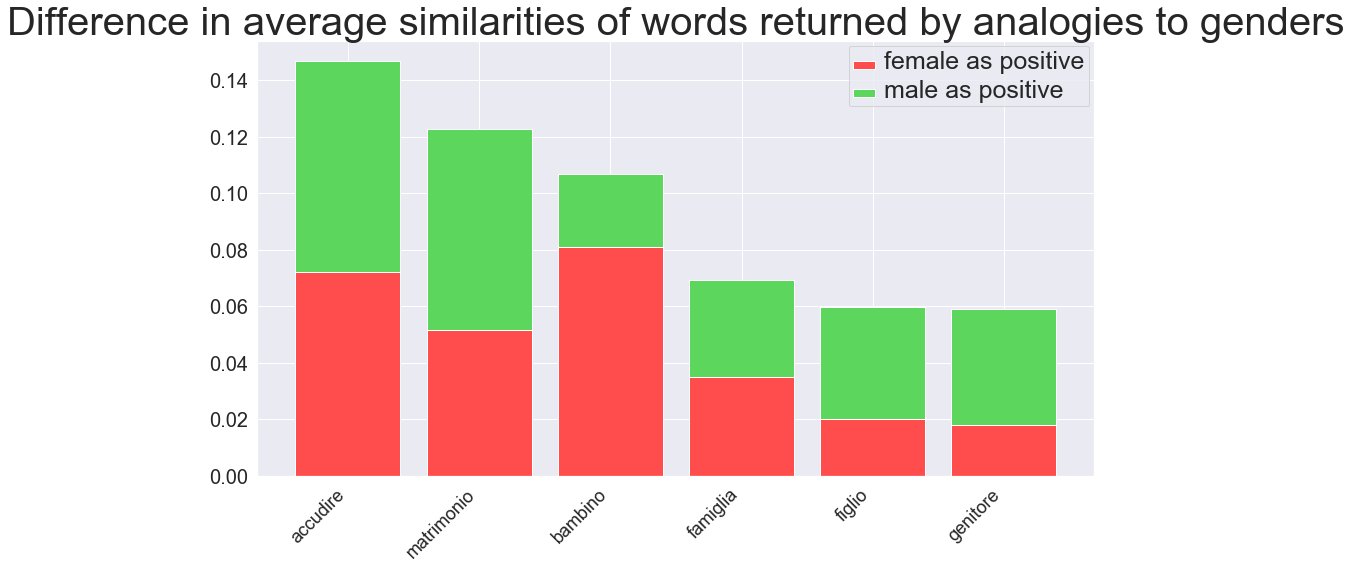

In [14]:
score.plot_bias()

---

In [15]:
score = Analogies_Distance_Bias(model.wv,
                                use_avg_gender=True,
                                type_most_similar = 'cosadd')
top_bias = score.get_top_bias(pred_positive_word='adj_positive', verbose=False)

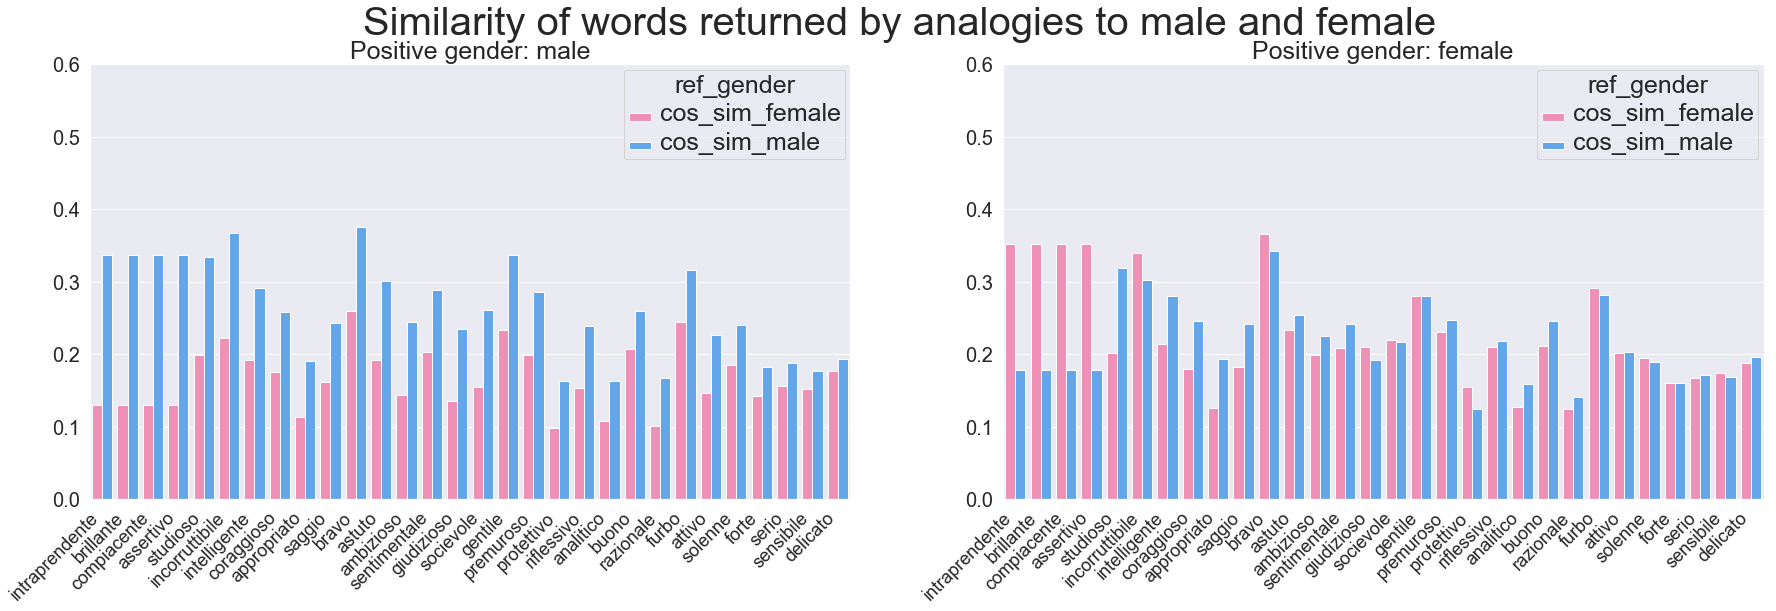

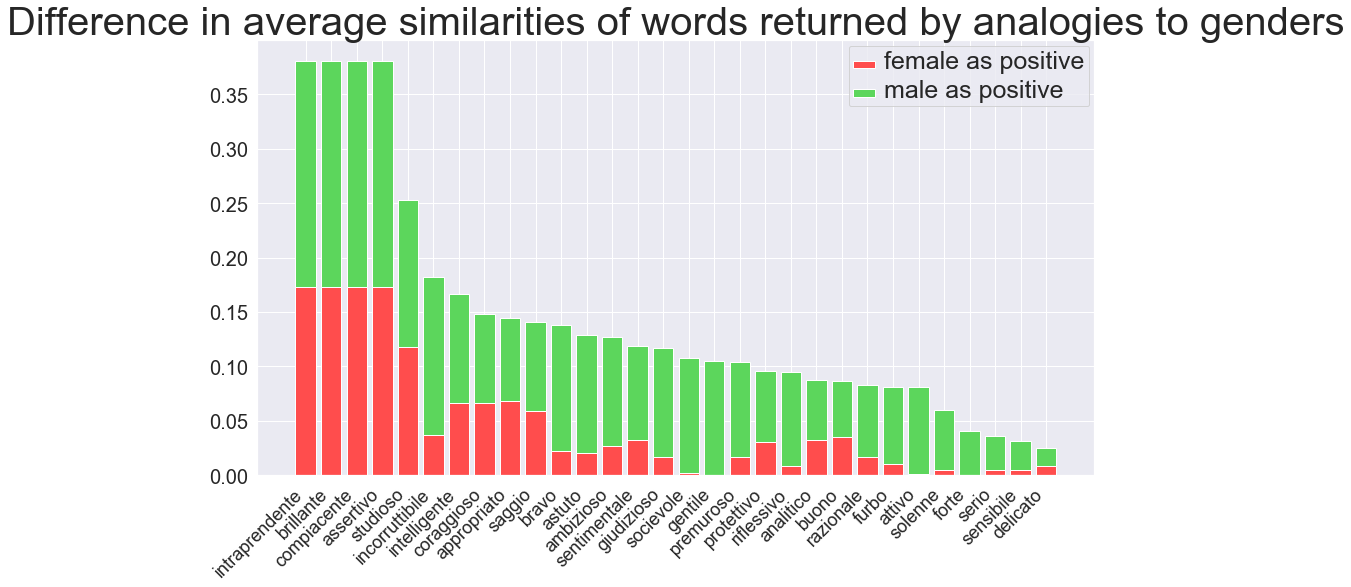

In [16]:
score.plot_bias()

---

# 3) WEAT and ECT

## WEAT

In [8]:
from INFORET_project import WEAT
from INFORET_project.data import gendered_neutral_words

In [3]:
model = load_embed_model('1948_1968')

In [9]:
WEAT(model.wv, 
     first_target={'name':'career', 'words': gendered_neutral_words['career']},
     second_target={'name':'family', 'words': gendered_neutral_words['family']},
     first_attribute={'name':'donna', 'words': gendered_neutral_words['female']},
     second_attribute={'name':'uomo', 'words': gendered_neutral_words['male']}
)

# WEAT result (score, size effect, Nt, Na and p-value)
# score: z-score. result of the test statistic
# size effect: intensity of the effect, how much the 2 samples are separated
# p-value: The null hypothesis is that there is no difference between the two sets of target words in 
#terms of their relative similarity to the two sets of attribute words.
# Nt: dimension of target (6x2: 6 words for 2 targets)
# Na: dimension of attributes (8x2: 8 words for 2 attributes)

# low p-value, so H0 rejected

{'Target words': 'career vs. family',
 'Attrib. words': 'donna vs. uomo',
 's': -0.752927340567112,
 'd': -1.6041145,
 'p': 0.9989177489177489,
 'Nt': '10x2',
 'Na': '3x2'}

In [10]:
WEAT(model.wv, 
     first_target={'name':'male_stereotypes', 'words': gendered_neutral_words['male_stereotypes']},
     second_target={'name':'female_stereotypes', 'words': gendered_neutral_words['female_stereotypes']},
     first_attribute={'name':'donna', 'words': gendered_neutral_words['female']},
     second_attribute={'name':'uomo', 'words': gendered_neutral_words['male']}
)

{'Target words': 'male_stereotypes vs. female_stereotypes',
 'Attrib. words': 'donna vs. uomo',
 's': -0.24709320068359375,
 'd': -0.95323783,
 'p': 0.9557109557109557,
 'Nt': '7x2',
 'Na': '3x2'}

## ECT

In [11]:
from INFORET_project.utils import fast_cosine_sim, calculate_avg_vector
from INFORET_project import ECT

In [12]:
spearman_corr, pval = ECT(model.wv, 
                          gendered_neutral_words['female'], 
                          gendered_neutral_words['male'], 
                          neutral_words = gendered_neutral_words['family'])

ECT for words: ['famiglia', 'figlio', 'matrimonio', 'genitore', 'bambino', 'accudire']

Spearman correlation has value 0.7714 with p-value 0.0724
High correlation --> Low bias

Cosine similarity of 'famiglia' to 'female' is 0.3612, to 'male' is 0.3747
Cosine similarity of 'figlio' to 'female' is 0.4409, to 'male' is 0.4577
Cosine similarity of 'matrimonio' to 'female' is 0.3251, to 'male' is 0.3103
Cosine similarity of 'genitore' to 'female' is 0.3743, to 'male' is 0.4375
Cosine similarity of 'bambino' to 'female' is 0.5360, to 'male' is 0.4293
Cosine similarity of 'accudire' to 'female' is 0.3432, to 'male' is 0.3072


In [16]:
spearman_corr, pval = ECT(model.wv, 
                          gendered_neutral_words['female'], 
                          gendered_neutral_words['male'], 
                          neutral_words = gendered_neutral_words['career'])

ECT for words: ['capo', 'presidente', 'onorevole', 'potere', 'carriera', 'salario', 'lavoro', 'professionale', 'denaro', 'ambizione']

Spearman correlation has value 0.4182 with p-value 0.2291
Moderate correlation --> Moderate bias

Cosine similarity of 'capo' to 'female' is 0.1374, to 'male' is 0.1829
Cosine similarity of 'presidente' to 'female' is 0.1468, to 'male' is 0.2569
Cosine similarity of 'onorevole' to 'female' is 0.1621, to 'male' is 0.2763
Cosine similarity of 'potere' to 'female' is 0.1830, to 'male' is 0.2610
Cosine similarity of 'carriera' to 'female' is 0.2111, to 'male' is 0.1765
Cosine similarity of 'salario' to 'female' is 0.2812, to 'male' is 0.2145
Cosine similarity of 'lavoro' to 'female' is 0.1026, to 'male' is 0.1105
Cosine similarity of 'professionale' to 'female' is 0.2597, to 'male' is 0.2347
Cosine similarity of 'denaro' to 'female' is 0.1057, to 'male' is 0.1724
Cosine similarity of 'ambizione' to 'female' is 0.2159, to 'male' is 0.1939


In [9]:
spearman_corr, pval = ECT(model.wv, 
                          gendered_neutral_words['female'], 
                          gendered_neutral_words['male'], 
                          neutral_words = gendered_neutral_words['female_stereotypes'])

ECT for words: ['bello', 'superficiale', 'frivolo', 'sensibile', 'delicato', 'gentile', 'passivo', 'silenzioso', 'insicuro', 'illogico', 'isterico', 'debole', 'irrazionale']

Spearman correlation has value 0.6538 with p-value 0.0153
Moderate correlation --> Moderate bias

Cosine similarity of 'bello' to 'female' is 0.2014, to 'male' is 0.2699
Cosine similarity of 'superficiale' to 'female' is 0.1012, to 'male' is 0.0804
Cosine similarity of 'frivolo' to 'female' is 0.3124, to 'male' is 0.4547
Cosine similarity of 'sensibile' to 'female' is 0.2410, to 'male' is 0.2043
Cosine similarity of 'delicato' to 'female' is 0.2247, to 'male' is 0.1971
Cosine similarity of 'gentile' to 'female' is 0.2040, to 'male' is 0.2745
Cosine similarity of 'passivo' to 'female' is 0.2332, to 'male' is 0.1659
Cosine similarity of 'silenzioso' to 'female' is 0.2856, to 'male' is 0.2322
Cosine similarity of 'insicuro' to 'female' is 0.3190, to 'male' is 0.2932
Cosine similarity of 'illogico' to 'female' is 0.07

In [18]:
spearman_corr, pval = ECT(model.wv, 
                          gendered_neutral_words['female'], 
                          gendered_neutral_words['male'], 
                          neutral_words = gendered_neutral_words['male_stereotypes'])

ECT for words: ['intelligente', 'razionale', 'saggio', 'ambizioso', 'forte', 'crudele', 'intollerante']

Spearman correlation has value 0.9643 with p-value 0.0005
High correlation --> Low bias

Cosine similarity of 'intelligente' to 'female' is 0.2679, to 'male' is 0.3162
Cosine similarity of 'razionale' to 'female' is 0.1441, to 'male' is 0.1110
Cosine similarity of 'saggio' to 'female' is 0.2478, to 'male' is 0.2573
Cosine similarity of 'ambizioso' to 'female' is 0.1682, to 'male' is 0.2052
Cosine similarity of 'forte' to 'female' is 0.2035, to 'male' is 0.2288
Cosine similarity of 'crudele' to 'female' is 0.3126, to 'male' is 0.2876
Cosine similarity of 'intollerante' to 'female' is 0.3143, to 'male' is 0.3642


In [30]:
spearman_corr, pval = ECT(model.wv, 
                          gendered_neutral_words['female'], 
                          gendered_neutral_words['male'], 
                          neutral_words = gendered_neutral_words['rage'])

ECT for words: ['intollerante', 'crudele', 'isterico', 'aggressivo', 'brutale', 'odioso', 'cattivo']

Spearman correlation has value 0.8571 with p-value 0.0137
High correlation --> Low bias

Cosine similarity of 'intollerante' to 'female' is 0.2680, to 'male' is 0.2491
Cosine similarity of 'crudele' to 'female' is 0.2685, to 'male' is 0.2354
Cosine similarity of 'isterico' to 'female' is 0.2520, to 'male' is 0.2439
Cosine similarity of 'aggressivo' to 'female' is 0.1572, to 'male' is 0.1096
Cosine similarity of 'brutale' to 'female' is 0.2082, to 'male' is 0.1489
Cosine similarity of 'odioso' to 'female' is 0.2511, to 'male' is 0.1883
Cosine similarity of 'cattivo' to 'female' is 0.1634, to 'male' is 0.1506


In [31]:
spearman_corr, pval = ECT(model.wv, 
                          gendered_neutral_words['female'], 
                          gendered_neutral_words['male'], 
                          neutral_words = gendered_neutral_words['kindness'])

ECT for words: ['premuroso', 'sensibile', 'delicato', 'buono', 'bravo']

Spearman correlation has value 0.3000 with p-value 0.6238
Moderate correlation --> Moderate bias

Cosine similarity of 'premuroso' to 'female' is 0.4219, to 'male' is 0.4423
Cosine similarity of 'sensibile' to 'female' is 0.2052, to 'male' is 0.1993
Cosine similarity of 'delicato' to 'female' is 0.1560, to 'male' is 0.1426
Cosine similarity of 'buono' to 'female' is 0.1840, to 'male' is 0.2057
Cosine similarity of 'bravo' to 'female' is 0.1441, to 'male' is 0.3304


In [32]:
spearman_corr, pval = ECT(model.wv, 
                          gendered_neutral_words['female'], 
                          gendered_neutral_words['male'], 
                          neutral_words = gendered_neutral_words['active'])

ECT for words: ['ambizioso', 'forte', 'assertivo', 'sicuro']

Spearman correlation has value 0.8000 with p-value 0.2000
High correlation --> Low bias

Cosine similarity of 'ambizioso' to 'female' is 0.1076, to 'male' is 0.1195
Cosine similarity of 'forte' to 'female' is 0.1613, to 'male' is 0.1652
Cosine similarity of 'assertivo' to 'female' is 0.2730, to 'male' is 0.2641
Cosine similarity of 'sicuro' to 'female' is 0.1501, to 'male' is 0.2230


In [33]:
spearman_corr, pval = ECT(model.wv, 
                          gendered_neutral_words['female'], 
                          gendered_neutral_words['male'], 
                          neutral_words = gendered_neutral_words['passive'])

ECT for words: ['timido', 'passivo', 'insicuro', 'debole']

Spearman correlation has value 0.4000 with p-value 0.6000
Moderate correlation --> Moderate bias

Cosine similarity of 'timido' to 'female' is 0.1413, to 'male' is 0.0818
Cosine similarity of 'passivo' to 'female' is 0.2038, to 'male' is 0.1974
Cosine similarity of 'insicuro' to 'female' is 0.2750, to 'male' is 0.1942
Cosine similarity of 'debole' to 'female' is 0.2337, to 'male' is 0.2131


In [34]:
spearman_corr, pval = ECT(model.wv, 
                          gendered_neutral_words['female'], 
                          gendered_neutral_words['male'], 
                          neutral_words = gendered_neutral_words['intelligence'])

ECT for words: ['intelligente', 'razionale', 'saggio', 'studioso', 'serio']

Spearman correlation has value 0.6000 with p-value 0.2848
Moderate correlation --> Moderate bias

Cosine similarity of 'intelligente' to 'female' is 0.1905, to 'male' is 0.2639
Cosine similarity of 'razionale' to 'female' is 0.0948, to 'male' is 0.1226
Cosine similarity of 'saggio' to 'female' is 0.2104, to 'male' is 0.2332
Cosine similarity of 'studioso' to 'female' is 0.1374, to 'male' is 0.2804
Cosine similarity of 'serio' to 'female' is 0.1004, to 'male' is 0.1440


In [11]:
spearman_corr, pval = ECT(model.wv, 
                          gendered_neutral_words['female'], 
                          gendered_neutral_words['male'], 
                          neutral_words = gendered_neutral_words['dumbness'])

ECT for words: ['illogico', 'irrazionale', 'stupido', 'superficiale']

Spearman correlation has value 1.0000 with p-value 0.0000
High correlation --> Low bias

Cosine similarity of 'illogico' to 'female' is 0.1155, to 'male' is 0.0661
Cosine similarity of 'irrazionale' to 'female' is 0.1216, to 'male' is 0.0806
Cosine similarity of 'stupido' to 'female' is 0.2806, to 'male' is 0.3270
Cosine similarity of 'superficiale' to 'female' is 0.1665, to 'male' is 0.1251


---

In [ ]:
# comparazoone metodi diversi
# ob funzioni: capire qnd parola legata a genere
# fai ranking parole, se i metodi sono robusti.
# studia intersezioni tra parole
# fai manualmente liste di parole polarizzate e parole neutre, vedi
# se i metodi le trovano nella posizione giusta.
# applica debias e vedi differenze?
# baseline: dividi i doc in 2 gruppi M,F e calcola misura di specificità di
#parole (TFIDF, PMI) per vedere se sono caratteristiche.
# i metodi fanno meglio? 

# correlazione tra stereotipi e numero di donne in aumento del parlamentoà

In [ ]:
sns.barplot(x='projection', y='word', data=projections_df,
                    palette=projections_df['color'])

In [ ]:
 def plot_projection_scores(self, words, n_extreme=10,
                               ax=None, axis_projection_step=None):
        """Plot the projection scalar of words on the direction.
        :param list words: The words tor project
        :param int or None n_extreme: The number of extreme words to show
        :return: The ax object of the plot
        """

        projections_df = self._calc_projection_scores(words)
        projections_df['projection'] = projections_df['projection'].round(2)

        if n_extreme is not None:
            projections_df = take_two_sides_extreme_sorted(projections_df,
                                                           n_extreme=n_extreme)

        if ax is None:
            _, ax = plt.subplots(1)

        if axis_projection_step is None:
            axis_projection_step = 0.1

        cmap = plt.get_cmap('RdBu')
        projections_df['color'] = ((projections_df['projection'] + 0.5)
                                   .apply(cmap))

        most_extream_projection = np.round(
            projections_df['projection']
            .abs()
            .max(),
            decimals=1)

        sns.barplot(x='projection', y='word', data=projections_df,
                    palette=projections_df['color'])

        plt.xticks(np.arange(-most_extream_projection,
                             most_extream_projection + axis_projection_step,
                             axis_projection_step))
        plt.title('← {} {} {} →'.format(self.negative_end,
                                        ' ' * 20,
                                        self.positive_end))

        plt.xlabel('Direction Projection')
        plt.ylabel('Words')

        return ax

In [ ]:
DIRECTION_METHODS = ['single', 'sum', 'pca']

def _identify_direction(self, positive_end, negative_end,
                            definitional, method='pca'):
    
    
        if method not in DIRECTION_METHODS:
            raise ValueError('method should be one of {}, {} was given'.format(
                DIRECTION_METHODS, method))

        if positive_end == negative_end:
            raise ValueError('positive_end and negative_end'
                             'should be different, and not the same "{}"'
                             .format(positive_end))
        if self._verbose:
            print('Identify direction using {} method...'.format(method))

        direction = None

        if method == 'single':
            if self._verbose:
                print('Positive definitional end:', definitional[0])
                print('Negative definitional end:', definitional[1])
            direction = normalize(normalize(self[definitional[0]])
                                  - normalize(self[definitional[1]]))

        elif method == 'sum':
            group1_sum_vector = np.sum([self[word]
                                        for word in definitional[0]], axis=0)
            group2_sum_vector = np.sum([self[word]
                                        for word in definitional[1]], axis=0)

            diff_vector = (normalize(group1_sum_vector)
                           - normalize(group2_sum_vector))

            direction = normalize(diff_vector)

        elif method == 'pca':
            pca = self._identify_subspace_by_pca(definitional, 10)
            if pca.explained_variance_ratio_[0] < FIRST_PC_THRESHOLD:
                raise RuntimeError('The Explained variance'
                                   'of the first principal component should be'
                                   'at least {}, but it is {}'
                                   .format(FIRST_PC_THRESHOLD,
                                           pca.explained_variance_ratio_[0]))
            direction = pca.components_[0]

            # if direction is opposite (e.g. we cannot control
            # what the PCA will return)
            ends_diff_projection = cosine_similarity((self[positive_end]
                                                      - self[negative_end]),
                                                     direction)
            if ends_diff_projection < 0:
                direction = -direction  # pylint: disable=invalid-unary-operand-type

        self.direction = direction
        self.positive_end = positive_end
        self.negative_end = negative_end

In [ ]:
 def _calc_projection_scores(self, words):
        self._is_direction_identified()

        df = pd.DataFrame({'word': words})

        # TODO: maybe using cosine_similarities on all the vectors?
        # it might be faster
        df['projection'] = df['word'].apply(self.project_on_direction)
        df = df.sort_values('projection', ascending=False)

        return df

In [ ]:
def take_two_sides_extreme_sorted(df, n_extreme,
                                  part_column=None,
                                  head_value='',
                                  tail_value=''):
    head_df = df.head(n_extreme)[:]
    tail_df = df.tail(n_extreme)[:]

    if part_column is not None:
        head_df[part_column] = head_value
        tail_df[part_column] = tail_value

    return (pd.concat([head_df, tail_df])
            .drop_duplicates()
            .reset_index(drop=True))